In [168]:
from Algorithms.clarke_wright import ClarkeWright
from Algorithms.client import Client
from datetime import datetime, timedelta
import random
import names
import numpy as np
import matplotlib.pyplot as plt

# Generate historized client data

In [169]:
def generate_clients(start_date, end_date, min_slots, max_slots, locations, max_timeslot_picks, timeslot_usage, num_clients=1):
    date_format = "%Y-%m-%d"
    start_date = datetime.strptime(start_date, date_format)
    end_date = datetime.strptime(end_date, date_format)
    date_range = (end_date - start_date).days
    
    timeslots = ['morning', 'evening']
    clients = []

    for _ in range(num_clients):
        name = names.get_full_name()  # Generating random full names
        location = random.choice(locations)
        
        while True:
            # Generate all possible availability slots within the entire date range
            possible_slots = []
            for day in (start_date + timedelta(days=i) for i in range(date_range + 1)):
                for timeslot in timeslots:
                    slot = f"{day.strftime(date_format)}_{timeslot}"
                    if timeslot_usage.get(slot, 0) < max_timeslot_picks:
                        possible_slots.append(slot)

            if len(possible_slots) < min_slots:
                raise ValueError(f"Unable to generate the minimum number of slots ({min_slots}) for client {name}.")
            
            random.shuffle(possible_slots)
            availability = possible_slots[:max_slots]

            # Generate appointment day that is before or on the same day as the latest timeslot in availability
            latest_slot_day = max(datetime.strptime(slot.split('_')[0], date_format) for slot in availability)
            appointment_day = start_date + timedelta(days=random.randint(0, (latest_slot_day - start_date).days))
            appointment_hour = random.randint(0, 23)
            appointment_minute = random.randint(0, 59)
            appointment_time = datetime.combine(appointment_day, datetime.min.time()) + timedelta(hours=appointment_hour, minutes=appointment_minute)
            appointment_time_str = appointment_time.strftime(f"{date_format} %H:%M:%S")

            for slot in availability:
                timeslot_usage[slot] = timeslot_usage.get(slot, 0) + 1
            
            if len(availability) >= min_slots:
                break

        client = Client(name, location, availability, appointment_time_str)
        clients.append(client)
    
    return clients

# test online case

In [170]:
def get_definitive_timeslot_clarke(client, scheduled_definitive_appointments, distance_matrix_path):
    old_routes = []
    new_routes = []
    slots = [slot for slot in client.availability if slot in scheduled_definitive_appointments]
    
    # If there are no appointments scheduled yet in the availability slots just schedule the client
    if not slots:
        slot = client.availability[0]
        clarkewright = ClarkeWright([client])
        clarkewright.solve(slot, distance_matrix_path)
        scheduled_definitive_appointments[slot] = [[client], clarkewright.get_solution()]
        return f"Client {client.name} has been scheduled for {slot}", scheduled_definitive_appointments
    
    # If there are appointments scheduled in the availability slots, try to add the client to the existing route with the minimal cost
    for slot in slots:
        old_routes.append([scheduled_definitive_appointments[slot], slot])
        clients_new = scheduled_definitive_appointments[slot][0] + [client]
        clarkewright_new = ClarkeWright(clients_new)
        clarkewright_new.solve(slot, distance_matrix_path)
        new_routes.append([[clients_new, clarkewright_new.get_solution()], slot])

    # Compare the costs of all routes and pick the route with the smallest delta
    min_delta = float('inf')
    best_route = None
    for old_route, new_route in zip(old_routes, new_routes):
        
        old_cost = old_route[0][1][1]  # Extracting the cost from the old route
        new_cost = new_route[0][1][1]  # Extracting the cost from the new route
        # convert string 1h34min to minutes
        old_cost = int(old_cost.split('h')[0])*60 + int(old_cost.split('h')[1].split('min')[0])
        new_cost = int(new_cost.split('h')[0])*60 + int(new_cost.split('h')[1].split('min')[0])
        delta = new_cost - old_cost
        if delta < min_delta:
            min_delta = delta
            best_route = new_route
    
    # Update the scheduled_definitive_appointments with the best route
    if best_route:
        slot = best_route[1]
        scheduled_definitive_appointments[slot] = [best_route[0][0], best_route[0][1]]
        return f"Client {client.name} has been scheduled for {slot} with the minimal delta cost.", scheduled_definitive_appointments

In [171]:

config = {
    'num_clients': 150,
    'start_date': "2024-06-01",
    'end_date': "2024-07-29",
    'min_slots': 2,
    'max_slots': 2,
    'locations': ['Asten Heusden Ommel', 'Deurne Vlierden', 'Geldrop', 'Gemert Handel', 'Helmond',
                  'Helmond Brandevoort', 'Mierlo', 'Nuenen Gerwen Nederwetten', 'Someren'],
    'distance_matrix_path': "..//Data//distance_matrix.csv",
    'batch_size': 7,  # For offline use case, processing batches of clients every 7 days
    'max_timeslot_picks': 3  # Maximum number of timeslots a single slot can be picked
}

# random seed
random.seed(42)

In [172]:
def online_use_case(config):
    scheduled_definitive_appointments = {}
    timeslot_usage = {}
    daily_travel_time = {}
    
    for _ in range(config['num_clients']):
        clients = generate_clients(config['start_date'], config['end_date'], config['min_slots'], config['max_slots'], config['locations'], config['max_timeslot_picks'], timeslot_usage, num_clients=1)
        client = clients[0]
        message, scheduled_definitive_appointments = get_definitive_timeslot_clarke(client, scheduled_definitive_appointments, config['distance_matrix_path'])
        
        # Collect travel time per day
        for slot, details in scheduled_definitive_appointments.items():
            day = slot.split('_')[0]
            # convert string 1h34min to minutes
            daily_travel_time[day] = daily_travel_time.get(day, 0) + int(details[1][1].split('h')[0])*60 + int(details[1][1].split('h')[1].split('min')[0])
    
    return daily_travel_time
        

In [173]:
print("Online Use Case Results:")
online_data = online_use_case(config)
print(online_data)

Online Use Case Results:
{'2024-06-05': 17400, '2024-06-23': 36903, '2024-07-07': 27708, '2024-07-27': 61013, '2024-06-14': 23665, '2024-07-14': 30521, '2024-06-24': 28321, '2024-07-10': 18296, '2024-06-20': 43746, '2024-06-13': 37120, '2024-07-23': 25406, '2024-06-02': 17000, '2024-06-22': 20210, '2024-06-17': 30034, '2024-07-25': 20318, '2024-06-29': 26274, '2024-06-10': 28269, '2024-06-27': 14500, '2024-06-19': 14678, '2024-06-25': 12880, '2024-07-24': 18367, '2024-07-06': 8814, '2024-06-18': 15069, '2024-07-17': 14865, '2024-06-03': 33136, '2024-07-19': 23308, '2024-06-07': 22374, '2024-07-18': 13896, '2024-07-26': 15192, '2024-06-09': 8888, '2024-07-28': 19768, '2024-06-04': 8736, '2024-07-15': 14735, '2024-07-16': 12078, '2024-06-06': 10385, '2024-06-26': 17775, '2024-07-05': 13256, '2024-07-09': 15440, '2024-06-15': 4860, '2024-06-12': 6968, '2024-07-04': 7540, '2024-06-21': 7308, '2024-07-12': 10770, '2024-07-08': 4260, '2024-07-29': 6792, '2024-07-03': 7530, '2024-06-16': 5560

# test offline case

In [174]:
def offline_use_case(config):
    scheduled_definitive_appointments = {}
    timeslot_usage = {}
    daily_travel_time = {}
    
    clients = generate_clients(config['start_date'], config['end_date'], config['min_slots'], config['max_slots'], config['locations'], config['max_timeslot_picks'], timeslot_usage, num_clients=config['num_clients'])
    for client in clients:
        message, scheduled_definitive_appointments = get_definitive_timeslot_clarke(client, scheduled_definitive_appointments, config['distance_matrix_path'])
        
        # Collect travel time per day
        for slot, details in scheduled_definitive_appointments.items():
            day = slot.split('_')[0]
            daily_travel_time[day] = daily_travel_time.get(day, 0) + int(details[1][1].split('h')[0])*60 + int(details[1][1].split('h')[1].split('min')[0])
    
    return daily_travel_time

In [175]:
print("Generating Offline Use Case Data...")
batch_sizes = [1, 3, 5, 7, 10]  # Different batch sizes to test
offline_data = {}
for batch_size in batch_sizes:
    offline_config = config.copy()
    offline_config['batch_size'] = batch_size
    offline_data[batch_size] = offline_use_case(offline_config)

Generating Offline Use Case Data...


In [178]:
def plot_travel_times(online_data, offline_data, batch_sizes):
    dates = sorted(set(str(date) for date in online_data.keys()).union(set(str(date) for date in offline_data.keys())))
    online_times = [online_data.get(date, 0) for date in dates]
    offline_times = {batch_size: [offline_data[batch_size].get(date, 0) for date in dates] for batch_size in batch_sizes}

    # print("Dates:", dates)
    # print("Online Times:", online_times)
    # print("Offline Times:", offline_times)

    plt.figure(figsize=(12, 6))
    
    plt.plot(dates, online_times, label='Online (one by one)')
    
    for batch_size in batch_sizes:
        plt.plot(dates, offline_times[batch_size], label=f'Offline (batch size: {batch_size})')
    
    plt.xlabel('Date')
    plt.ylabel('Total Travel Time (minutes)')
    plt.title('Total Travel Time per Day: Online vs Offline')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    
    plt.plot(dates, np.cumsum(online_times), label='Online (one by one)')
    
    for batch_size in batch_sizes:
        plt.plot(dates, np.cumsum(offline_times[batch_size]), label=f'Offline (batch size: {batch_size})')
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Travel Time (minutes)')
    plt.title('Cumulative Travel Time over Weeks: Online vs Offline')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

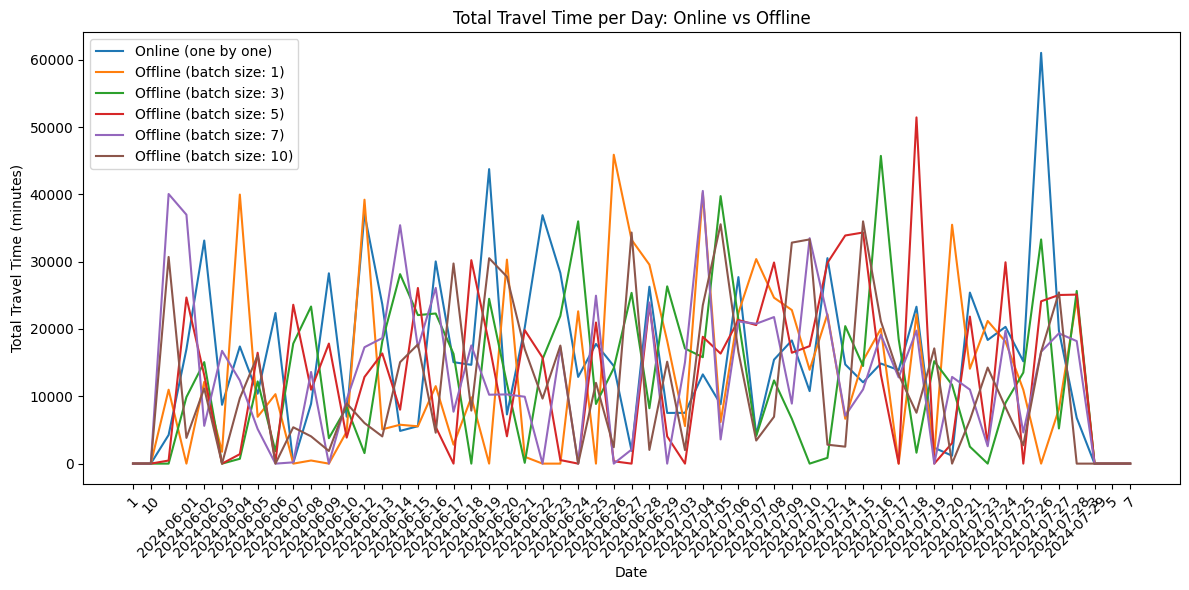

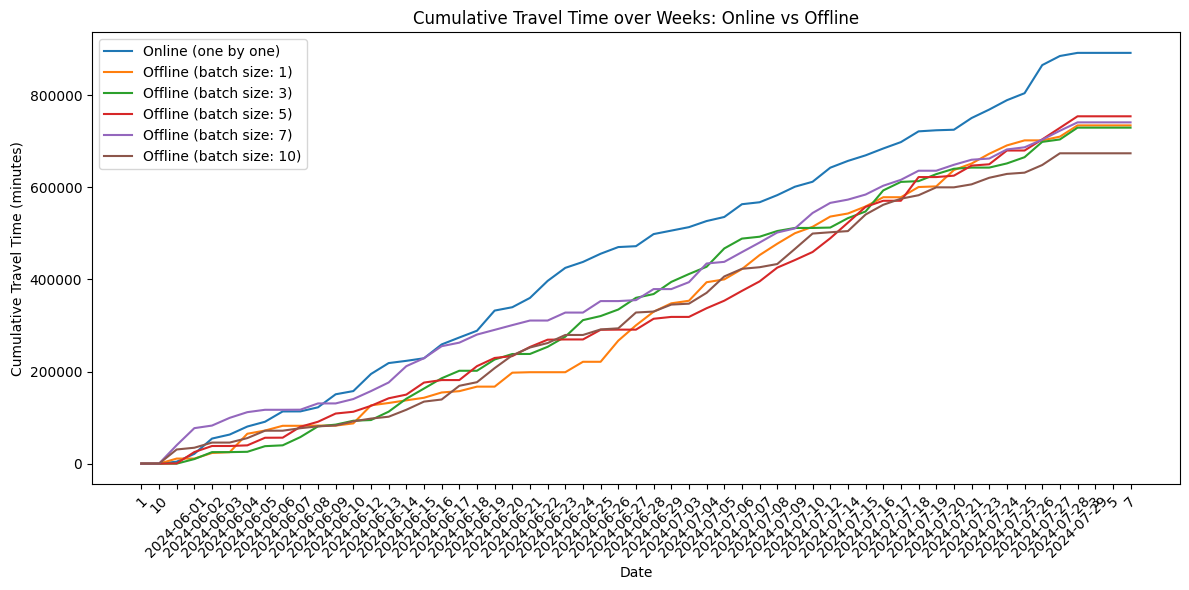

In [179]:
plot_travel_times(online_data, offline_data, batch_sizes)